In [1]:
import pandas as pd
import numpy as np

import tempfile
import requests
import zipfile
import os 

with tempfile.TemporaryDirectory() as temp_dir:
    response = requests.get("http://www.seaphe.org/databases/LSAC/LSAC_SAS.zip")
    temp_file_name = os.path.join(temp_dir, "LSAC_SAS.zip")
    with open(temp_file_name, "wb") as temp_file:
        temp_file.write(response.content)
    with zipfile.ZipFile(temp_file_name, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    df = pd.read_sas(os.path.join(temp_dir, "lsac.sas7bdat"))
    df = df.assign(gender=(df["gender"] == b"male") * 1)
    df['race'] = df['race1']
    df = df[['race','zfygpa']]

In [2]:
df.loc[df['race'] != b'white', 'race'] = 0
df.loc[df['race'] == b'white', 'race'] = 1
df.dropna(inplace=True)
df['zfygpa'] = (df['zfygpa'] - df['zfygpa'].min())/(df['zfygpa'].max() - df['zfygpa'].min())
df.sort_values(by='zfygpa', ascending=False, inplace=True)

In [3]:
def disc_cum_gain(scores: pd.Series, scores_full: pd.Series=None, r: int = None):
        if r is None:
             r = scores.shape[0]
        scores_ = scores[:r]
        z = _dcg(scores_)
        if not (scores_full is None):  
            scores_full_ = np.sort(scores_full)[::-1][:r]
            z /= _dcg(scores_full_)
        return z


def _dcg(scores: pd.Series):
    logs = np.log2(np.arange(2, len(scores)+2))
    z = np.sum((2**scores-1)/logs)
    return z

In [4]:
rng = np.random.default_rng(seed=42)

n = 100
df_proportion = []
df_noisy = df.copy()
df_var = df['zfygpa'].var()
df_infind = []
df_dcg = []

var_multipliers = np.arange(0, 50, step=1)
for c in var_multipliers:
    df_noisy = df.copy()
    # add noise
    noise = rng.laplace(scale=c*df_var, size=df_noisy.shape[0])
    df_noisy['zfygpa'] = df_noisy['zfygpa'].add(noise)
    # normalize
    max = df_noisy['zfygpa'].max()
    min = df_noisy['zfygpa'].min()
    df_noisy['zfygpa'] = (df_noisy['zfygpa'] - min)/(max - min)
    # measure how "wrong" the noisy ranking is:
    # sort noisy candidates by their clean scores and measure the dcg
    df_noisy_reindexed = df_noisy.reindex(df.index)
    df_dcg.append(disc_cum_gain(scores=df_noisy_reindexed['zfygpa'], scores_full=df['zfygpa'], r=100))
    # proportion of groups in top-n elements of noisy dataset (sorted by noisy scores)
    df_noisy_top = df_noisy.sort_values(by='zfygpa', ascending=False)[:n]
    df_proportion.append(df_noisy_top[df_noisy_top['race'] == 0].shape[0]/df_noisy_top[df_noisy_top['race'] == 1].shape[0])

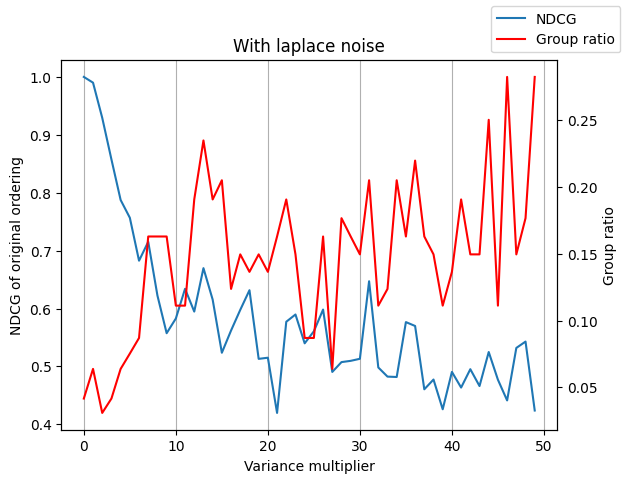

In [5]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_title("With laplace noise")
axes={'Variance multiplier': var_multipliers, 'Group ratio': df_proportion, 'NDCG': df_dcg}
ax1.plot('Variance multiplier', 'NDCG', data=axes)
ax1.set_ylabel("NDCG of original ordering")
ax1.set_xlabel("Variance multiplier")
ax2 = ax1.twinx()
ax2.plot('Variance multiplier', 'Group ratio',c='r', data=axes)
ax2.set_ylabel("Group ratio")
fig.legend()
ax1.grid(axis='x')

In [6]:
rng = np.random.default_rng(seed=42)

n = 100
df_proportion = []
df_noisy = df.copy()
df_var = df_noisy['zfygpa'].var()
df_infind = []
df_dcg = []
noise = np.zeros(df_noisy.shape[0])

var_multipliers = np.arange(0, 50, step=1)
for c in var_multipliers:
    df_noisy = df.copy()
    # add noise
    noise = rng.normal(loc=0, scale=c*df_var, size=df_noisy.shape[0])
    df_noisy['zfygpa'] += noise
    # normalize
    max = df_noisy['zfygpa'].max()
    min = df_noisy['zfygpa'].min()
    df_noisy['zfygpa'] = (df_noisy['zfygpa'] - min)/(max - min)
    # measure how "wrong" the noisy ranking is:
    # sort noisy candidates by their clean scores and measure the dcg
    df_noisy_reindexed = df_noisy.reindex(df.index)
    df_dcg.append(disc_cum_gain(scores=df_noisy_reindexed['zfygpa'], scores_full=df['zfygpa'], r=100))
    # proportion of groups in top-n elements of noisy dataset (sorted by noisy scores)
    df_noisy_top = df_noisy.sort_values(by='zfygpa', ascending=False)[:n]
    df_proportion.append(df_noisy_top[df_noisy_top['race'] == 0].shape[0]/df_noisy_top[df_noisy_top['race'] == 1].shape[0])

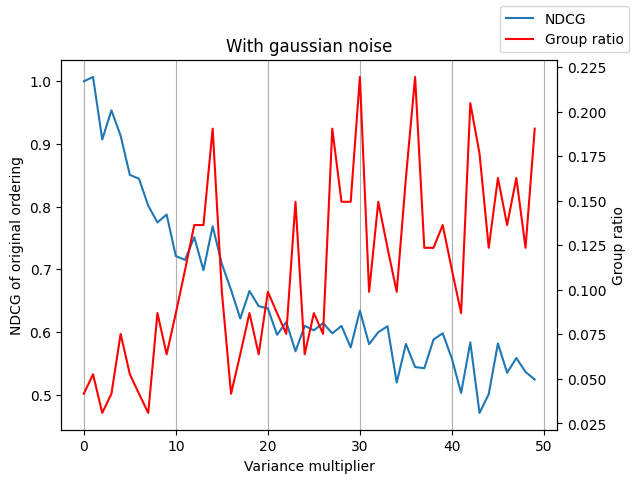

In [7]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_title("With gaussian noise")
axes={'Variance multiplier': var_multipliers, 'Group ratio': df_proportion, 'NDCG': df_dcg}
ax1.plot('Variance multiplier', 'NDCG', data=axes)
ax1.set_ylabel("NDCG of original ordering")
ax1.set_xlabel("Variance multiplier")
ax2 = ax1.twinx()
ax2.plot('Variance multiplier', 'Group ratio',c='r', data=axes)
ax2.set_ylabel("Group ratio")
fig.legend()
ax1.grid(axis='x')